# BOSS

### Imports

In [20]:
# some_file.py
import sys
import yaml
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/jaimerz/PhD/xCell')

from xcell.mappers import MapperBOSS
from xcell.mappers import utils
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import numpy as np

### Configurations

In [21]:
ells = [0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309, 351, 398, 452, 513, 582, 661, 750, 852, 967, 1098, 1247, 1416, 1536] #1608, 1826, 2073, 2354, 2673, 3072]
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [22]:
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [23]:
with open("../config_files/BOSS/CMASS.yml", 'r') as stream:
    config_CMASS = yaml.safe_load(stream)

with open("../config_files/BOSS/LOWZ.yml", 'r') as stream:
    config_LOWZ = yaml.safe_load(stream)

### Create maps

In [24]:
CMASS = MapperBOSS(config_CMASS)
LOWZ = MapperBOSS(config_LOWZ)

In [25]:
CMASS_map = CMASS.get_signal_map()
LOWZ_map = LOWZ.get_signal_map()

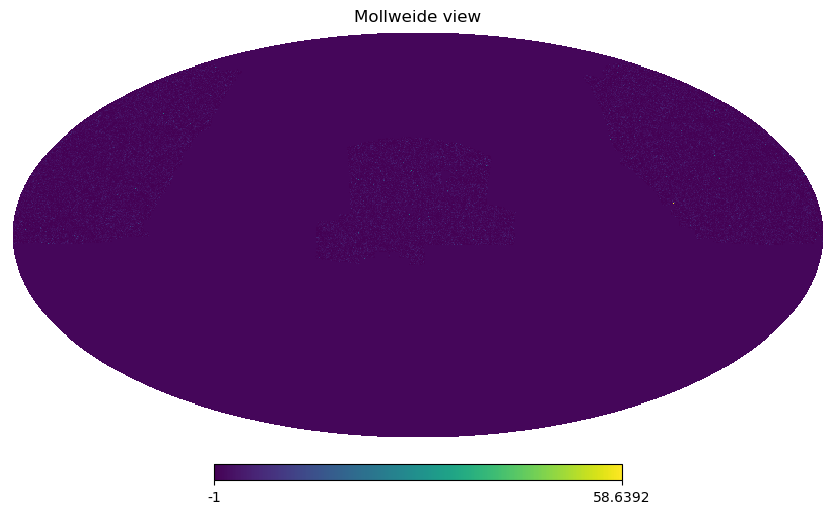

In [26]:
hp.visufunc.mollview(map=np.array(CMASS_map)[0])

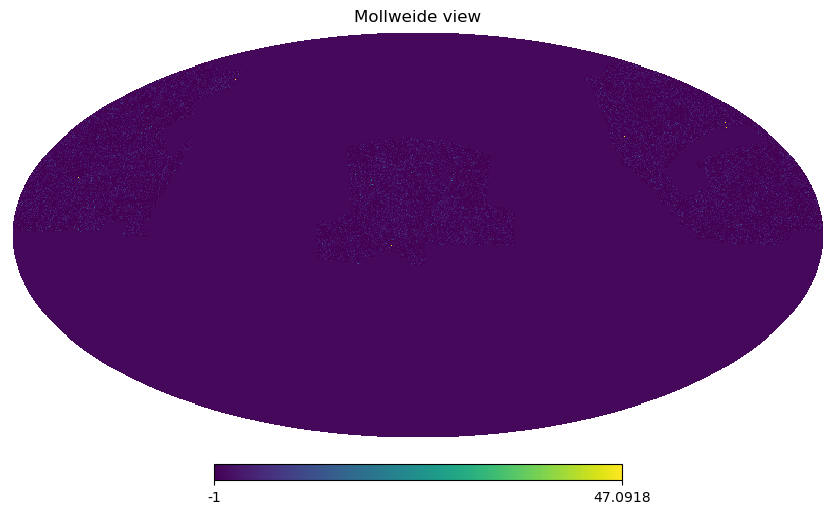

In [27]:
hp.visufunc.mollview(map=np.array(LOWZ_map)[0])

### Cl's

In [28]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
b_CMASS = config_CMASS["bias"]*np.ones(config_CMASS["num_z_bins"]) # https://arxiv.org/abs/1202.6057
b_LOWZ = config_LOWZ["bias"]*np.ones(config_LOWZ["num_z_bins"]) #https://arxiv.org/abs/1401.4171

In [29]:
CMASS_nz = CMASS.get_nz()
LOWZ_nz = LOWZ.get_nz()

CMASS_z = CMASS_nz[0]
CMASS_dNdz = CMASS_nz[1]
LOWZ_z = LOWZ_nz[0]
LOWZ_dNdz = LOWZ_nz[1]

In [30]:
CMASSt = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(CMASS_z, CMASS_dNdz), bias=(CMASS_z, b_CMASS))
LOWZt = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(LOWZ_z, LOWZ_dNdz), bias=(LOWZ_z, b_LOWZ))

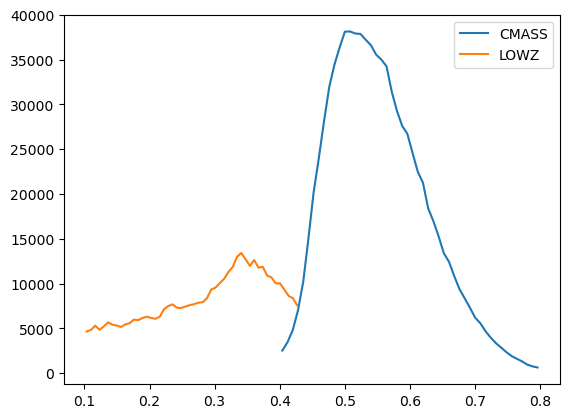

In [31]:
plt.plot(CMASS_z, CMASS_dNdz, label='CMASS')
plt.plot(LOWZ_z, LOWZ_dNdz, label='LOWZ')
plt.legend()
plt.show()

In [32]:
CMASSt_cl = ccl.angular_cl(cosmo, CMASSt, CMASSt, ell_arr) 
LOWZt_cl = ccl.angular_cl(cosmo, LOWZt, LOWZt, ell_arr) 

In [33]:
CMASS_f =  CMASS.get_nmt_field()
LOWZ_f =  LOWZ.get_nmt_field()

In [34]:
CMASS_w = nmt.NmtWorkspace()
CMASS_w.compute_coupling_matrix(CMASS_f, CMASS_f, bands)
LOWZ_w = nmt.NmtWorkspace()
LOWZ_w.compute_coupling_matrix(LOWZ_f, LOWZ_f, bands)

In [35]:
CMASS_cl_c = nmt.compute_coupled_cell(CMASS_f, CMASS_f)
LOWZ_cl_c = nmt.compute_coupled_cell(LOWZ_f, LOWZ_f)

In [36]:
CMASS_cl = CMASS_w.decouple_cell(CMASS_cl_c)
LOWZ_cl = LOWZ_w.decouple_cell(LOWZ_cl_c)

In [37]:
CMASS_nl_c = CMASS.get_nl_coupled() 
LOWZ_nl_c = LOWZ.get_nl_coupled() 

calculing nl from weights
calculing nl from weights


In [38]:
CMASS_nl = CMASS_w.decouple_cell(CMASS_nl_c)
LOWZ_nl = LOWZ_w.decouple_cell(LOWZ_nl_c)

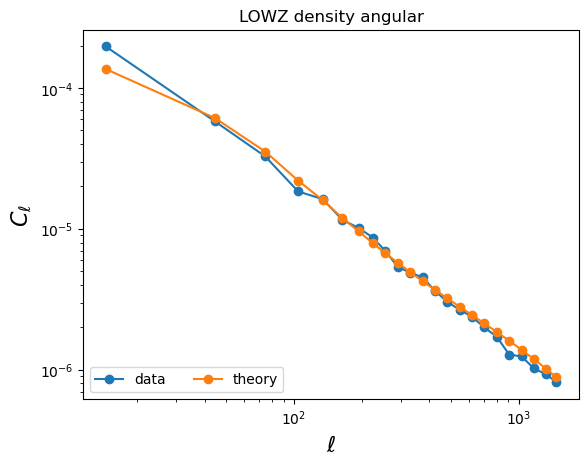

In [39]:
plt.plot(ell_arr, LOWZ_cl[0]-LOWZ_nl[0], 'o-', label='data')
plt.plot(ell_arr, LOWZt_cl, 'o-', label='theory')
plt.title('LOWZ density angular')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale('log')
plt.yscale('log')
plt.show()

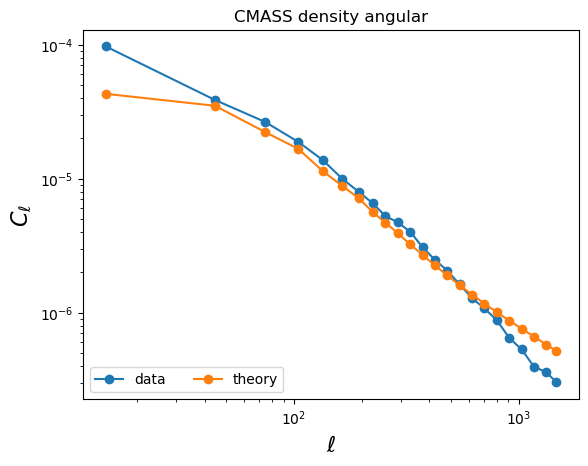

In [40]:
plt.plot(ell_arr, CMASS_cl[0]-CMASS_nl[0], 'o-', label='data')
plt.plot(ell_arr, CMASSt_cl, 'o-', label='theory')
plt.title('CMASS density angular')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale('log')
plt.yscale('log')
plt.show()